In [586]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from typing import List, Union, Tuple, Optional

In [588]:
def expand_matrix(original_matrix: np.ndarray, target_shape: Tuple[int, int]) -> np.ndarray:
    """
    Expands a matrix to a specified target shape by repeating its rows and columns.

    Parameters:
    - original_matrix (np.ndarray): The matrix to be expanded.
    - target_shape (Tuple[int, int]): A tuple specifying the desired number of rows and columns in the expanded matrix.

    Returns:
    - np.ndarray: The expanded matrix with the specified number of rows and columns.
    """
    original_rows, original_columns = original_matrix.shape
    target_rows, target_columns = target_shape
    
    # Calculate the number of times to repeat each row and column
    row_repeats = target_rows // original_rows
    column_repeats = target_columns // original_columns
    
    # Repeat rows and columns to expand the matrix
    expanded_matrix = np.repeat(np.repeat(original_matrix, row_repeats, axis=0), column_repeats, axis=1)
    
    return expanded_matrix


def calculate_weight_shape(initial_shape: Tuple[int, int], target_shape: Tuple[int, int]) -> Tuple[int, int]:
    """
    Calculates the shape of a weight matrix transitioning from an initial shape to a target shape.

    Parameters:
    - initial_shape (Tuple[int, int]): The shape of the matrix at the starting layer.
    - target_shape (Tuple[int, int]): The desired shape of the matrix at the target layer.

    Returns:
    - Tuple[int, int]: A tuple representing the shape (columns, rows) of the weight matrix.
    """
    initial_rows, initial_columns = initial_shape
    target_rows, target_columns = target_shape
    
    # Calculate the number of rows and columns in the weight matrices
    weight_rows = target_columns
    weight_columns = initial_columns
    
    return (weight_columns,weight_rows)



def expand_adjacency_matrix(neurons_per_layer: List[int], adjacency_matrix: np.ndarray) -> List[np.ndarray]:
    """
    Expands an adjacency matrix according to the number of neurons per layer, adjusting its shape for each layer.

    Parameters:
    - neurons_per_layer (List[int]): A list of integers where each integer represents the number of neurons in that layer.
    - adjacency_matrix (np.ndarray): The initial adjacency matrix.

    Returns:
    - List[np.ndarray]: A list of expanded adjacency matrices for each layer.
    """
    # Calculate target shapes for each layer based on the number of neurons
    target_shapes = [(1, neurons) for neurons in neurons_per_layer]
    
    # Initialize the expanded adjacency matrix list
    expanded_matrices = []
    
    initial_shape = (1, adjacency_matrix.shape[1])
    identity_matrix = np.eye(adjacency_matrix.shape[0], adjacency_matrix.shape[1], dtype=np.float32)
    
    for i, target_shape in enumerate(target_shapes):
        # Calculate the weight shape for the current layer
        weight_shape = calculate_weight_shape(initial_shape, target_shape)
        initial_shape = target_shape
        # Expand the adjacency matrix to match the weight shape
        expanded_matrix = expand_matrix(adjacency_matrix, weight_shape)
        
        if i >= 1:
            expanded_identity = expand_matrix(identity_matrix, weight_shape)
            expanded_matrix += expanded_identity
        
        # Append the expanded matrix to the list
        expanded_matrices.append(expanded_matrix)
    
    return expanded_matrices




In [589]:
def check_preds(model, dataset: torch.utils.data.Dataset, new_adj_matrix: Optional[np.ndarray] = None) -> None:
    """
    Evaluates predictions with a new adjacency matrix to simulate interventions on the causal system.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to be used for evaluating the model.
        new_adj_matrix (Optional[np.ndarray]): New adjacency matrix to be used to update the model's masks, if provided.
    """
    model.eval()
    if new_adj_matrix is not None:# Convert the numpy array to tensor
        # Update the masks based on the new adjacency matrix
        new_masks = [torch.from_numpy(mask).float().to(torch.float64) for mask in expand_adjacency_matrix(model.neurons_per_layer[1:], new_adj_matrix)]
        model.set_masks(new_masks)

    # Extract all data for plotting
    all_inputs = dataset[:][0]  # Assuming dataset is globally accessible and properly formatted

    with torch.no_grad():
        all_predictions = model(all_inputs, shuffle=False).numpy()

    if isinstance(all_inputs, torch.Tensor):
        actual_data = all_inputs.numpy()
    else:
        actual_data = all_inputs

    # Variables are assumed to be in columns: A, B, C, D
    variables = ['A', 'B', 'C', 'D']

    # Create scatter plots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    axes = axes.ravel()  # Flatten the axis array

    for i, ax in enumerate(axes):
        ax.scatter(actual_data[:, i], all_predictions[:, i], alpha=0.5)
        ax.set_title(f'Predicted vs Actual for {variables[i]}')
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.plot([actual_data[:, i].min(), actual_data[:, i].max()], 
                [actual_data[:, i].min(), actual_data[:, i].max()], 'k--')  # Diagonal line

    plt.tight_layout()
    plt.show()



class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
  



data shape: torch.Size([500, 4])


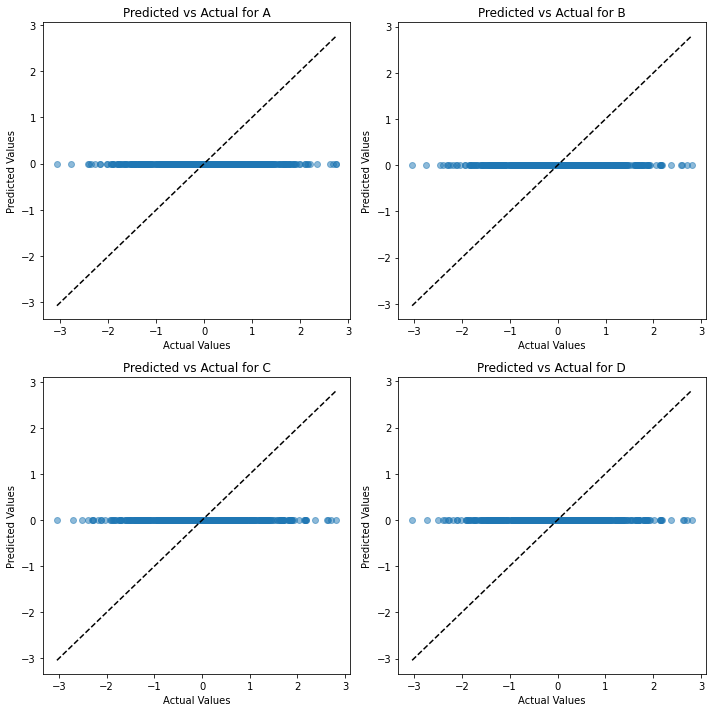

Epoch 10, Loss: 0.9998641346934828


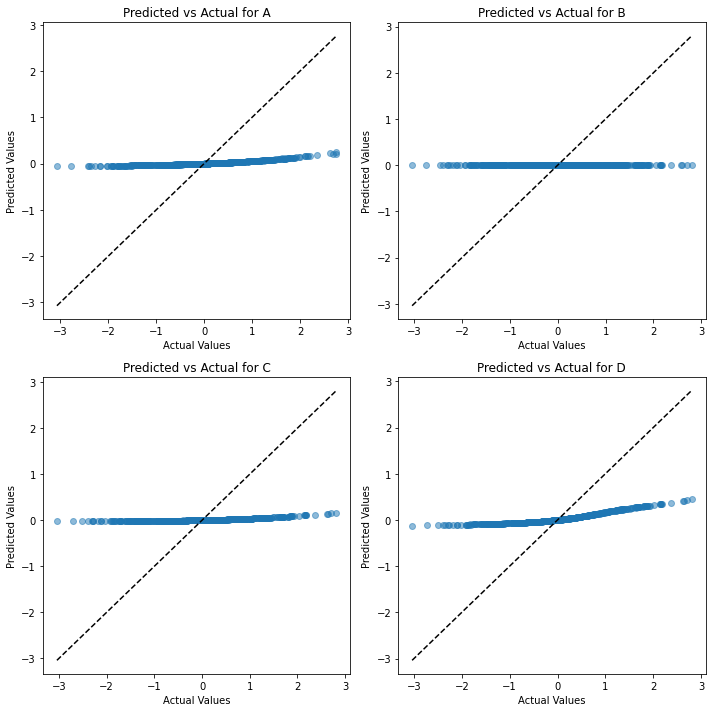

Epoch 110, Loss: 0.8559266569166464


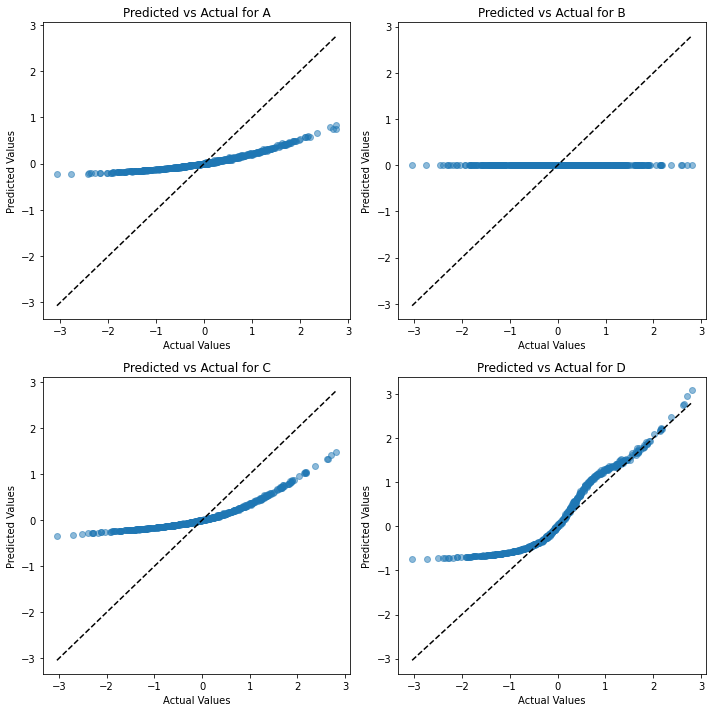

Epoch 210, Loss: 0.5843369593683606


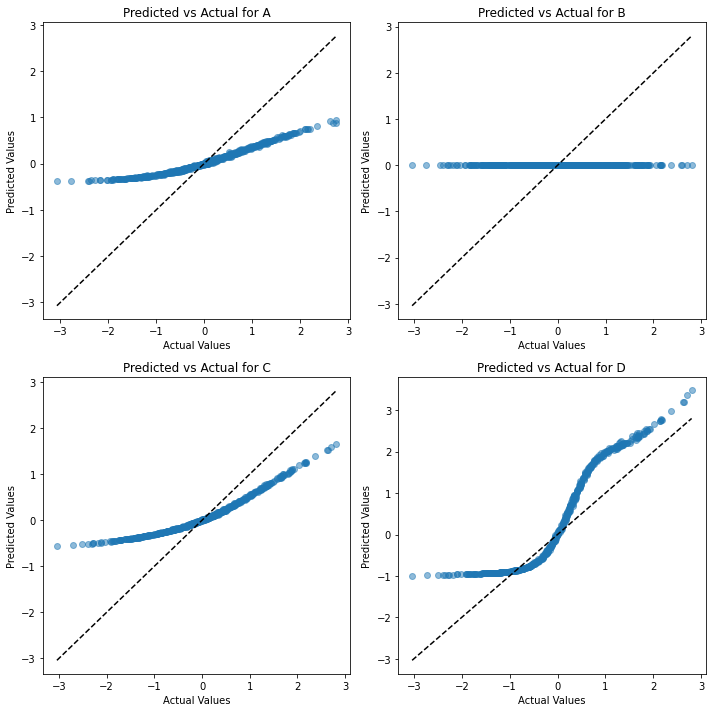

Epoch 310, Loss: 0.4941966935218619


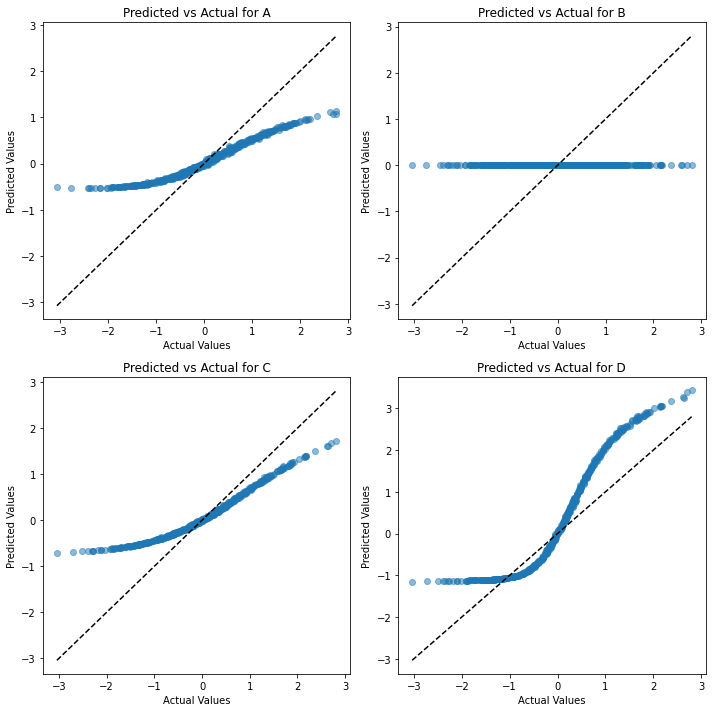

Epoch 410, Loss: 0.450658546669175


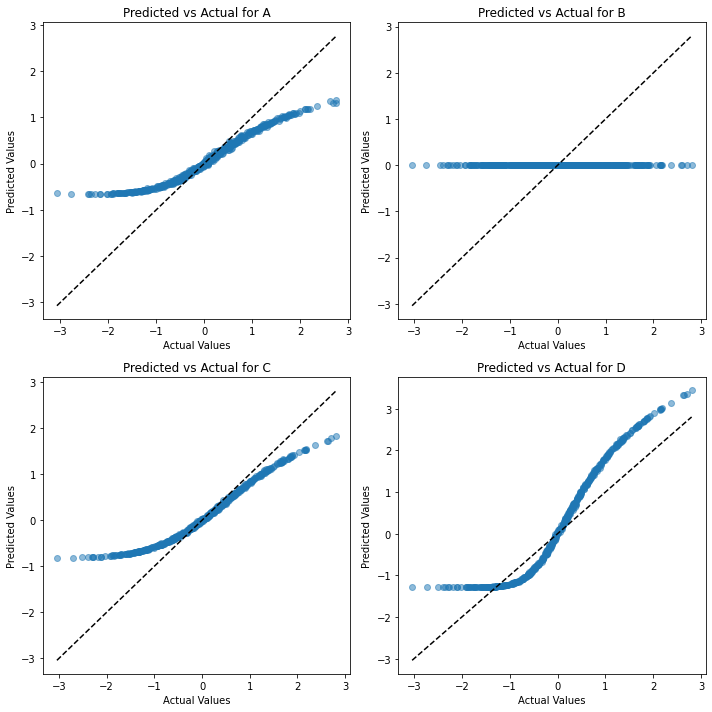

Epoch 510, Loss: 0.3914872501173508


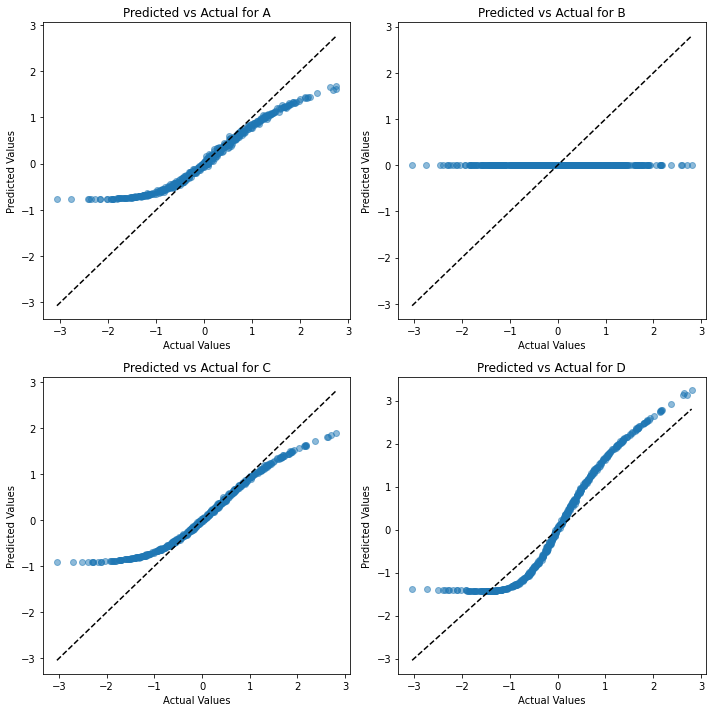

Epoch 610, Loss: 0.3762518679815268


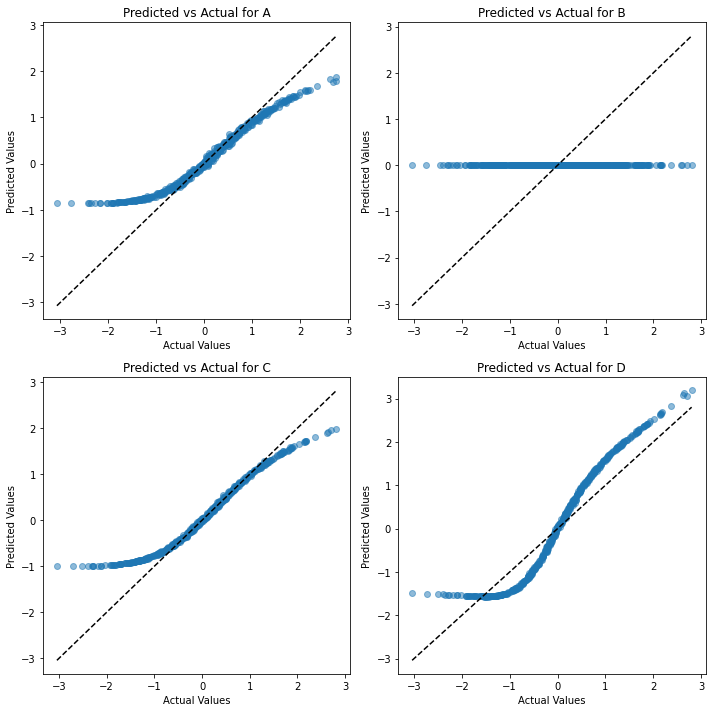

Epoch 710, Loss: 0.3400154747293957


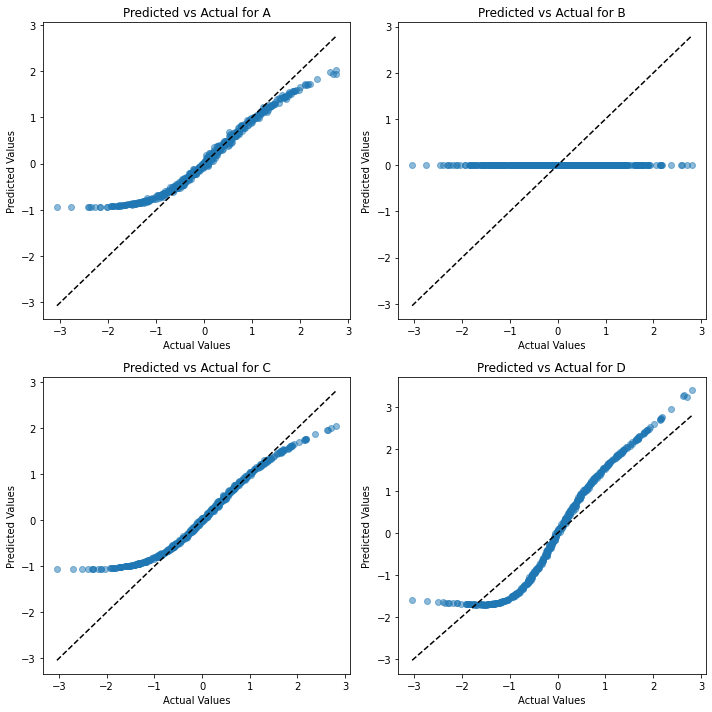

Epoch 810, Loss: 0.3222425143195656


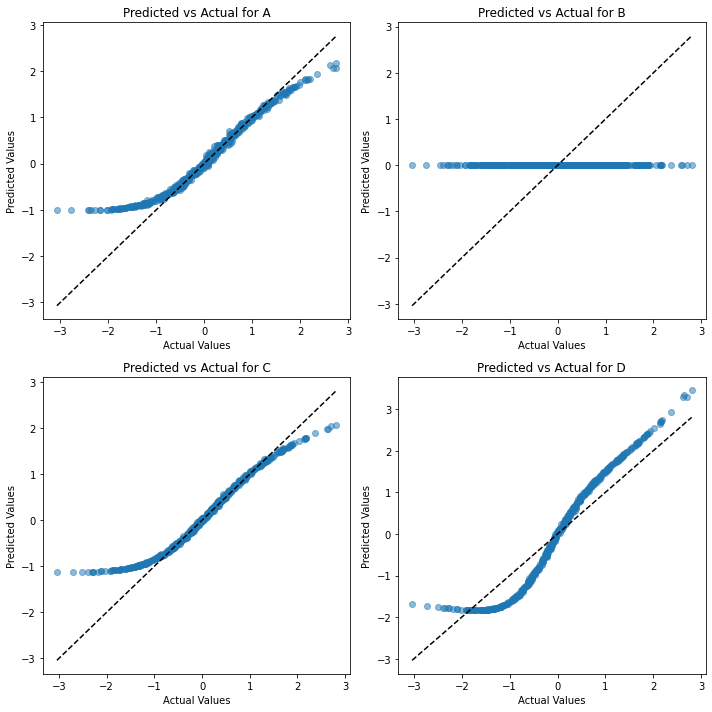

Epoch 910, Loss: 0.3141485096922622


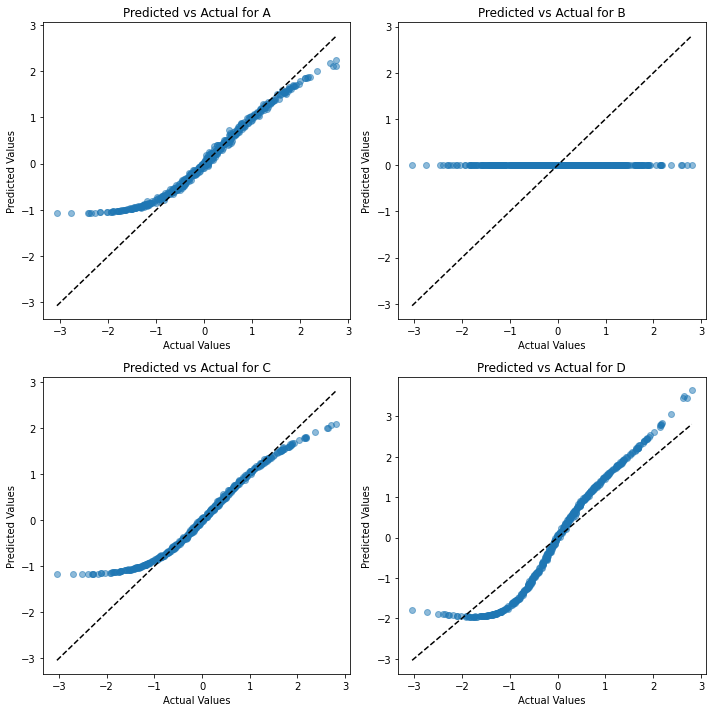

Epoch 1010, Loss: 0.3071268688811648


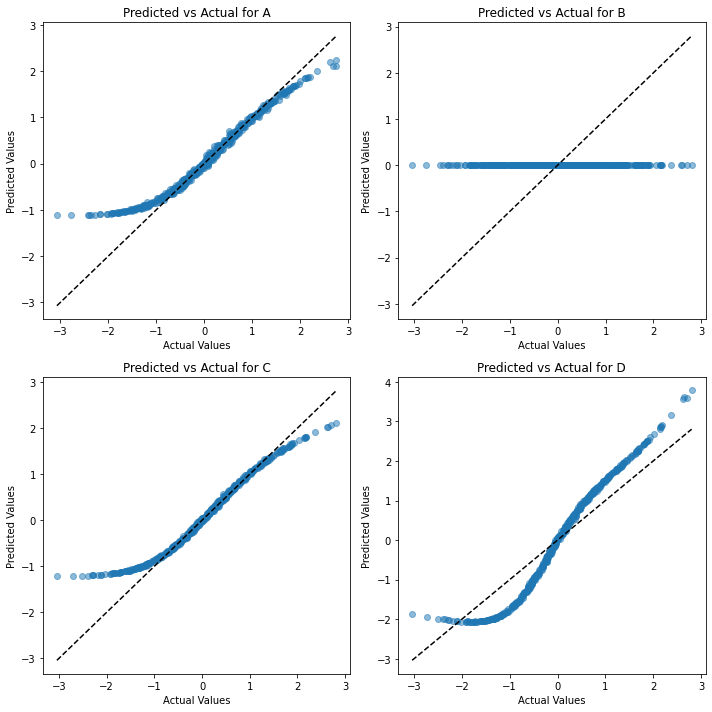

Epoch 1110, Loss: 0.3009016105960672


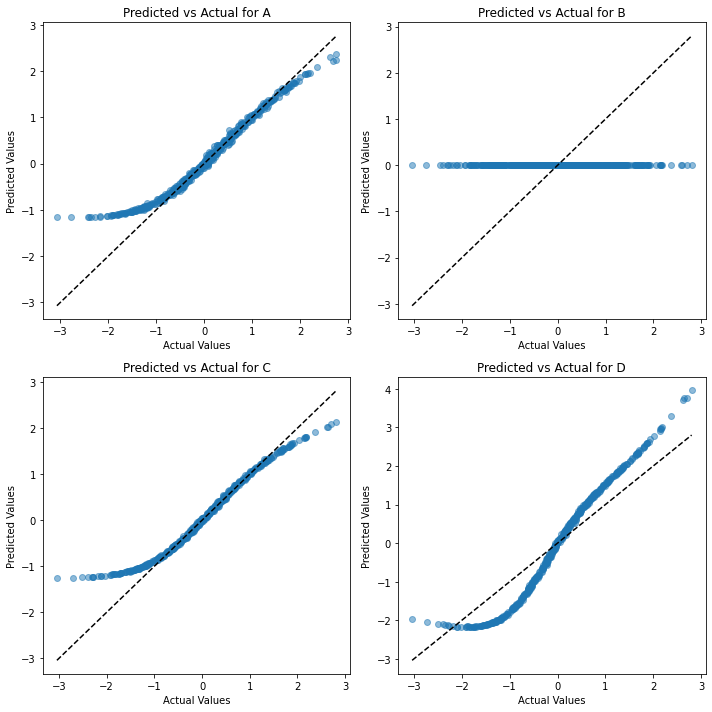

Epoch 1210, Loss: 0.2960759572532751


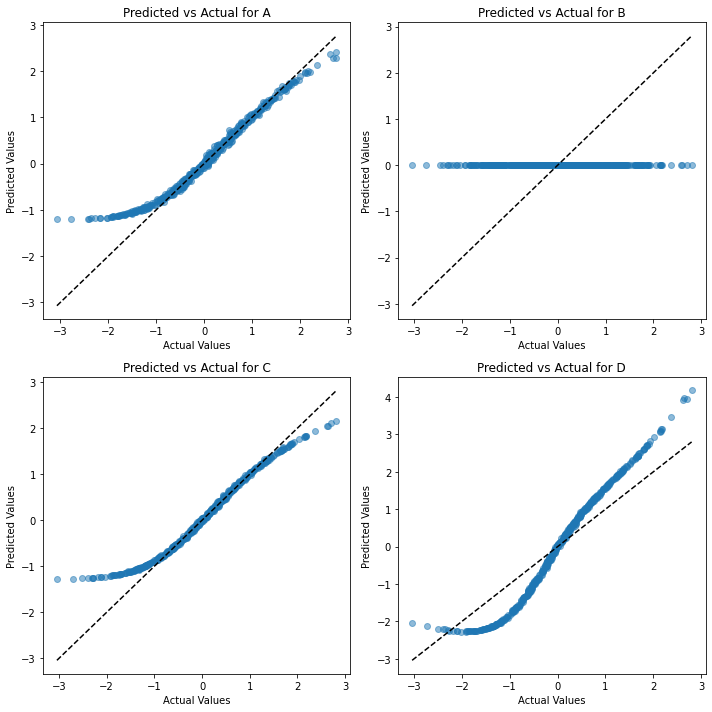

Epoch 1310, Loss: 0.2921449844006213


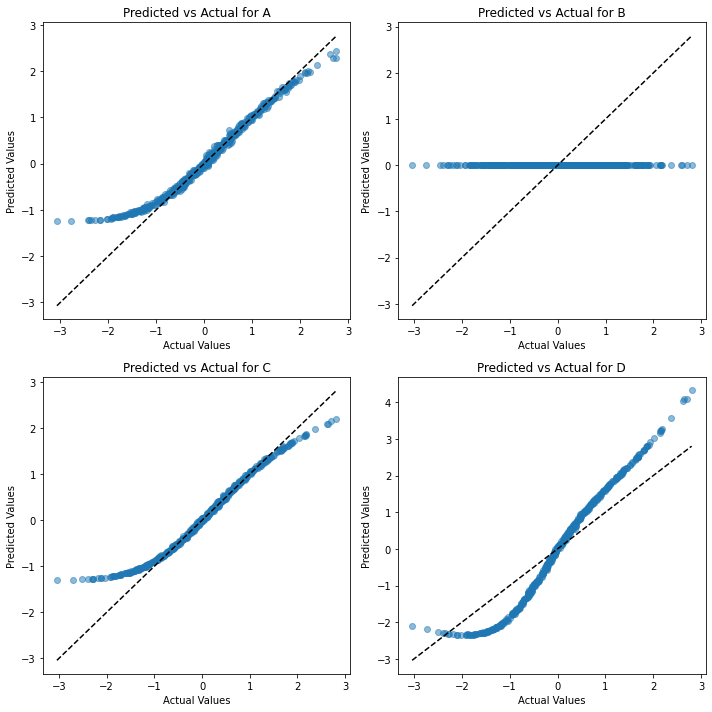

Epoch 1410, Loss: 0.28785452806775597


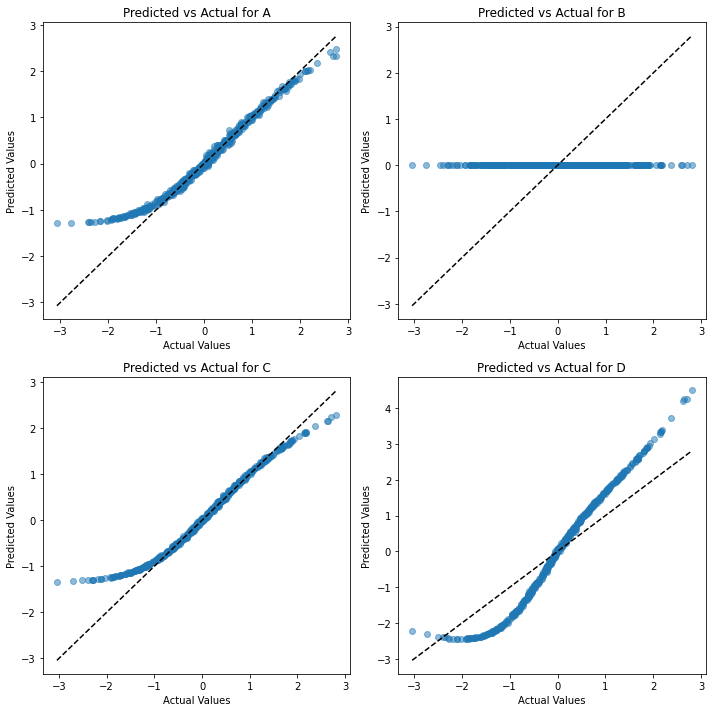

Epoch 1510, Loss: 0.28447350644796066


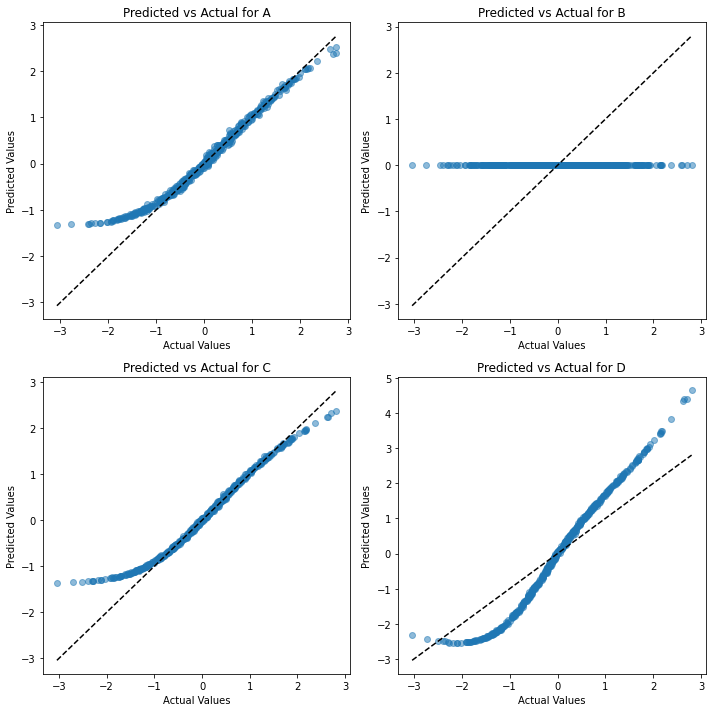

Epoch 1610, Loss: 0.28235761068650167


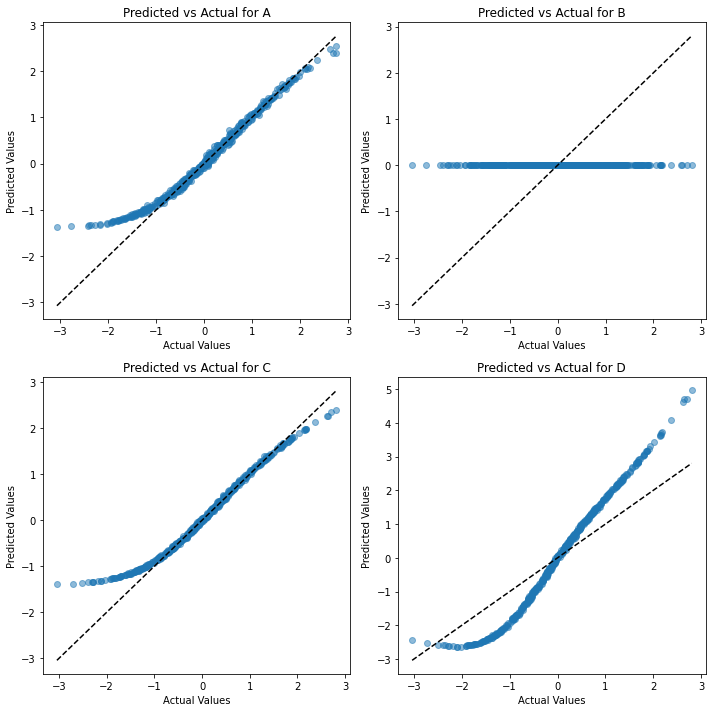

Epoch 1710, Loss: 0.2779257136794994


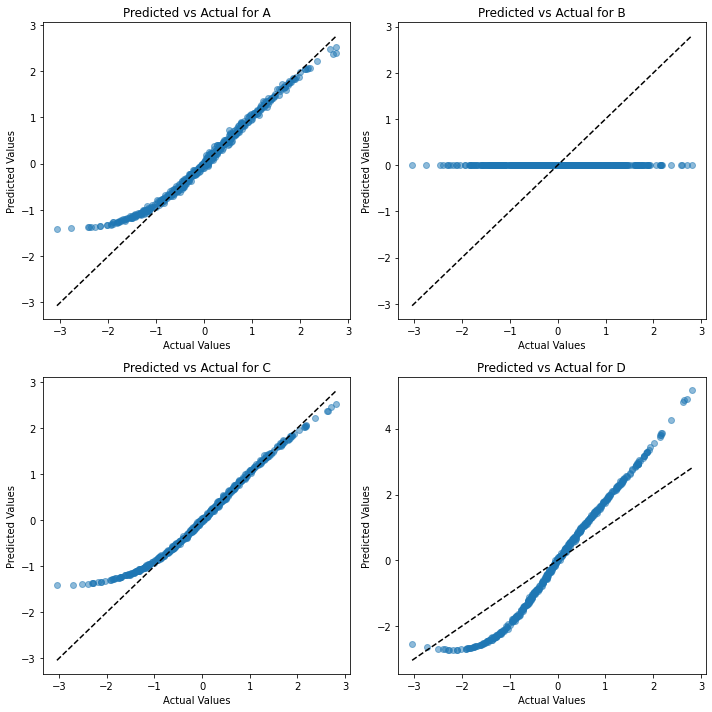

Epoch 1810, Loss: 0.27514972053492004


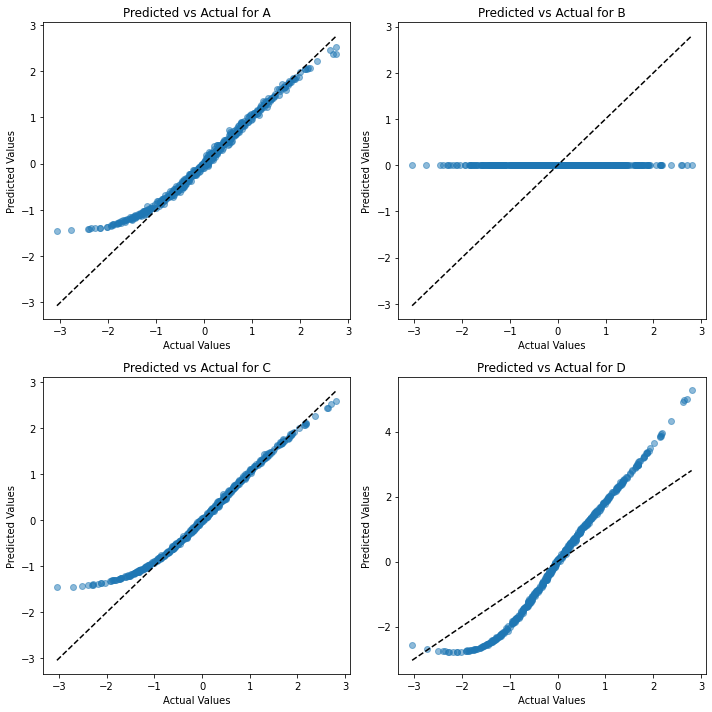

Epoch 1910, Loss: 0.26993117613202366


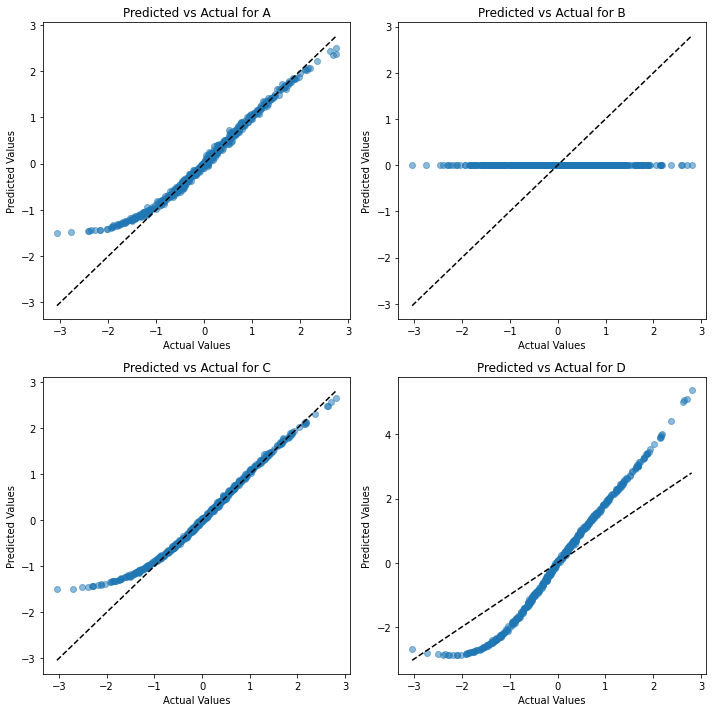

Epoch 2010, Loss: 0.26807310518395083


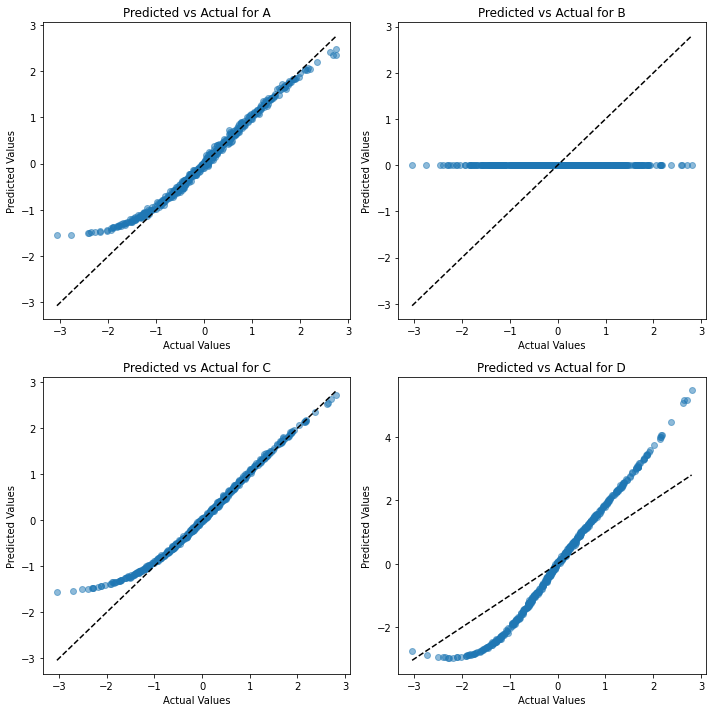

Epoch 2110, Loss: 0.26679108925020334


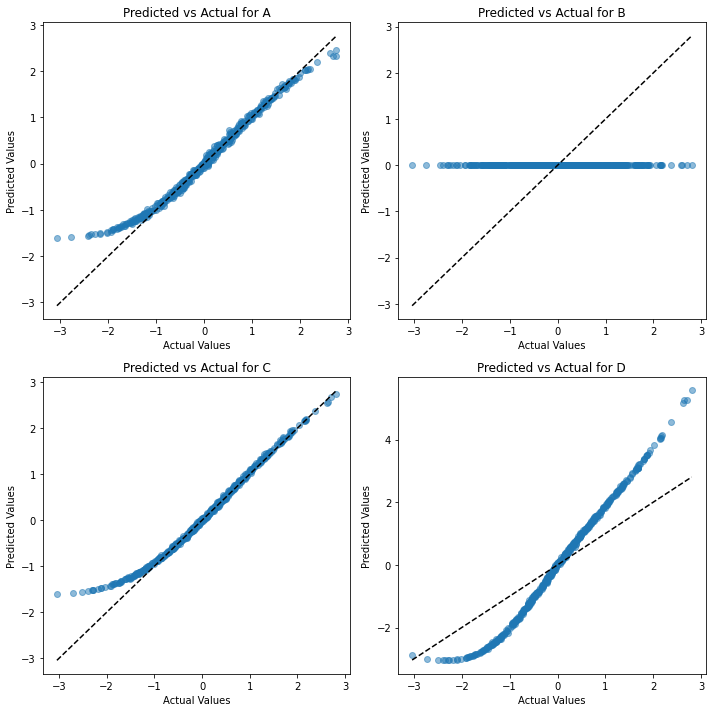

Epoch 2210, Loss: 0.263049555805133


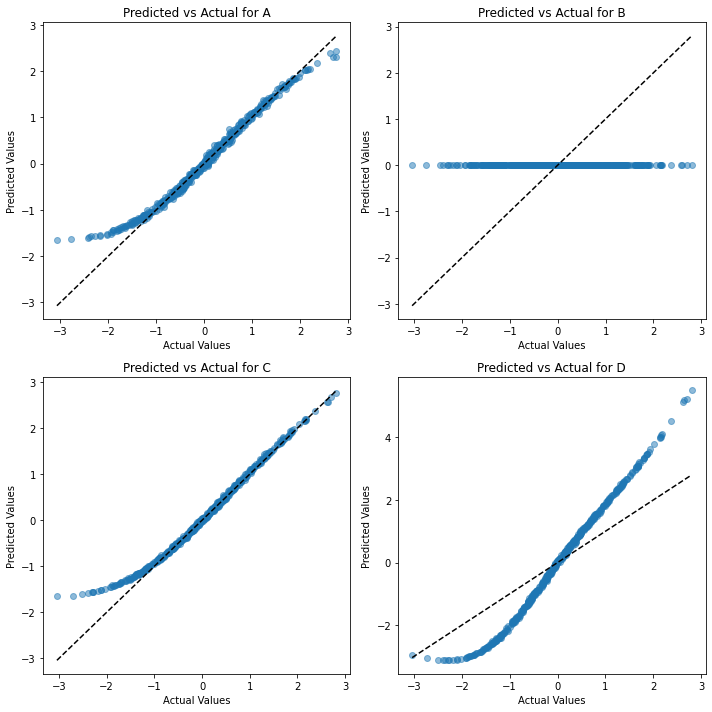

Epoch 2310, Loss: 0.2616712936525132


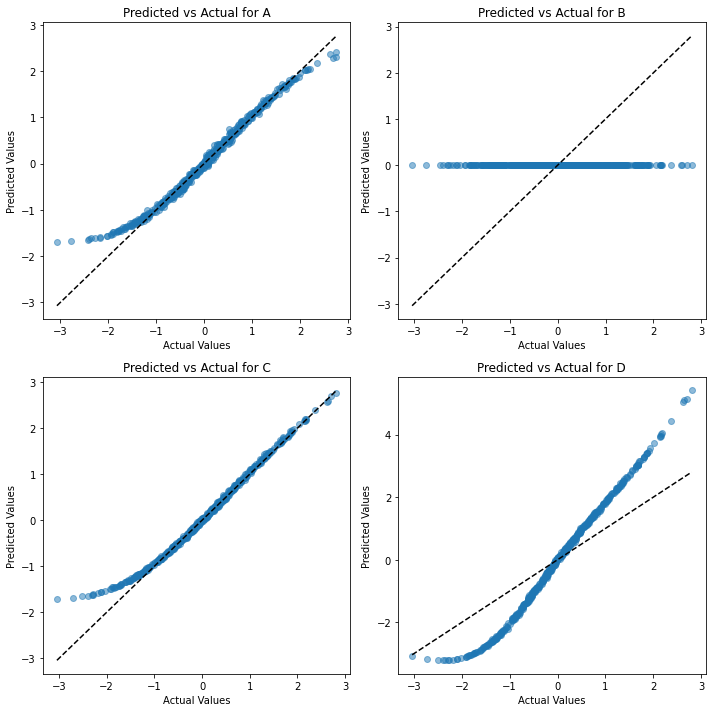

Epoch 2410, Loss: 0.2609627607558578


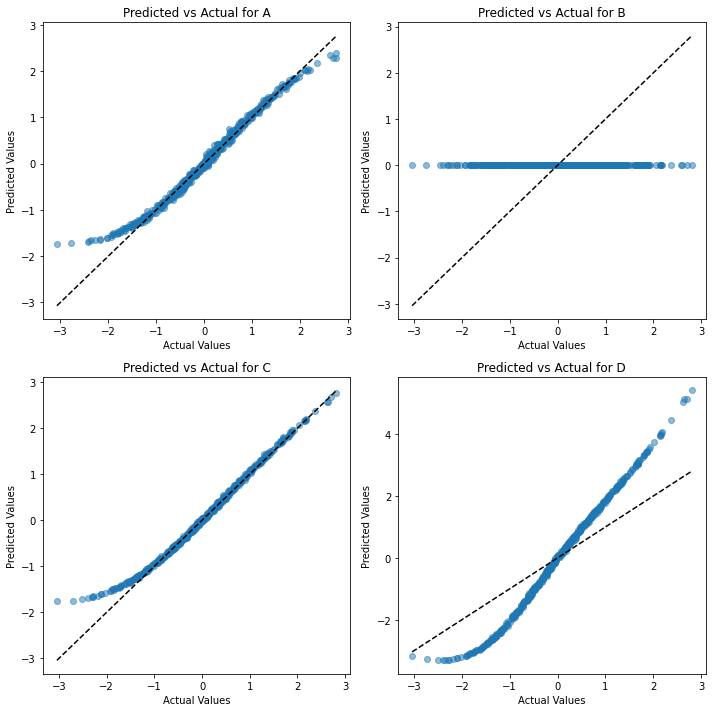

Epoch 2510, Loss: 0.2605239403134068


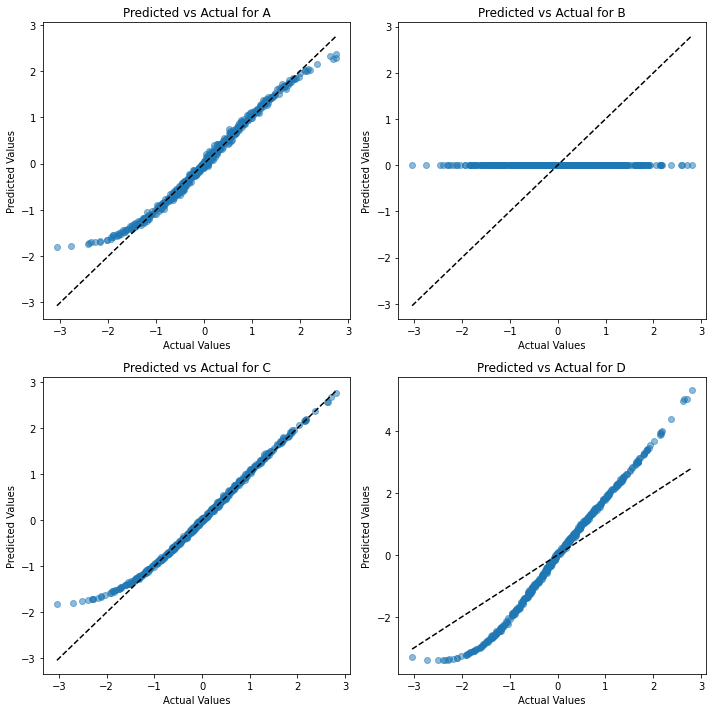

Epoch 2610, Loss: 0.25791762135717217


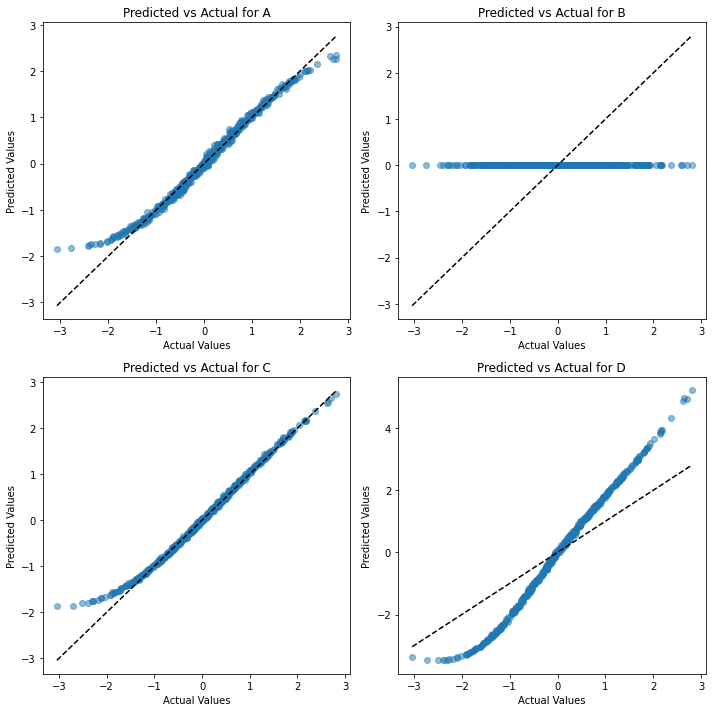

Epoch 2710, Loss: 0.25665956456936934


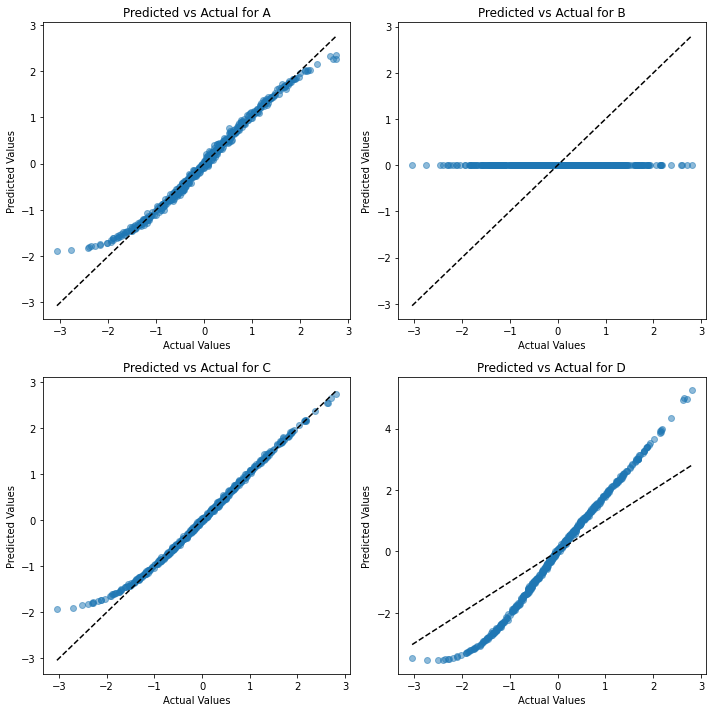

Epoch 2810, Loss: 0.25708383317434563


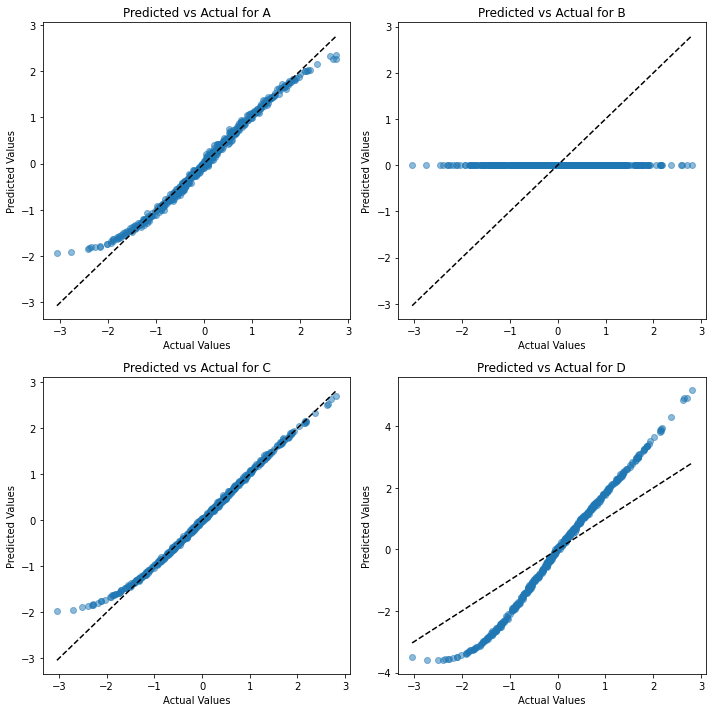

Epoch 2910, Loss: 0.25613238833183377


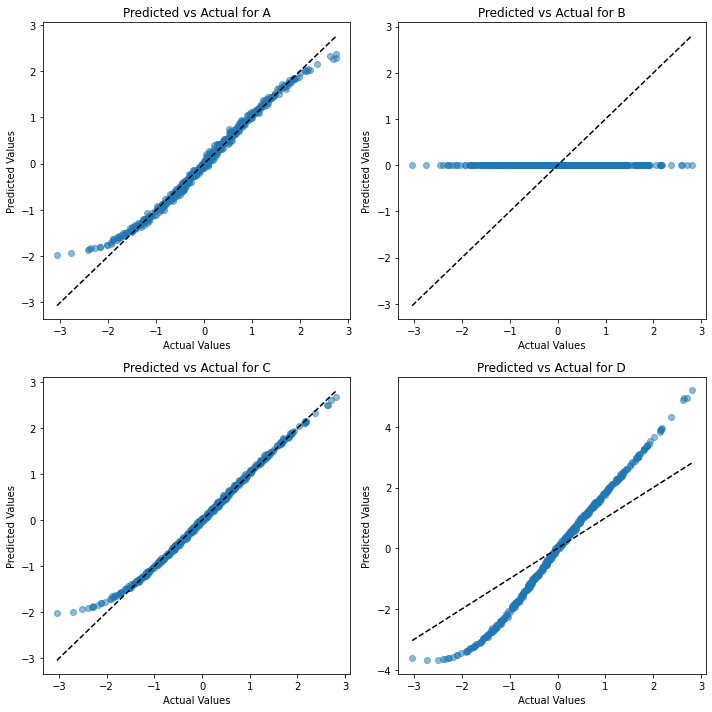

Epoch 3010, Loss: 0.25624771743947883


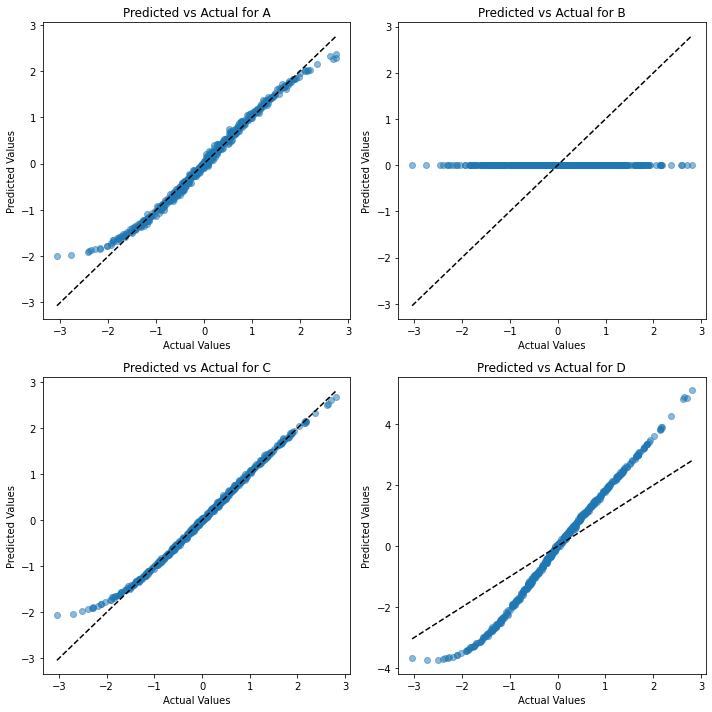

Epoch 3110, Loss: 0.25540723665511555


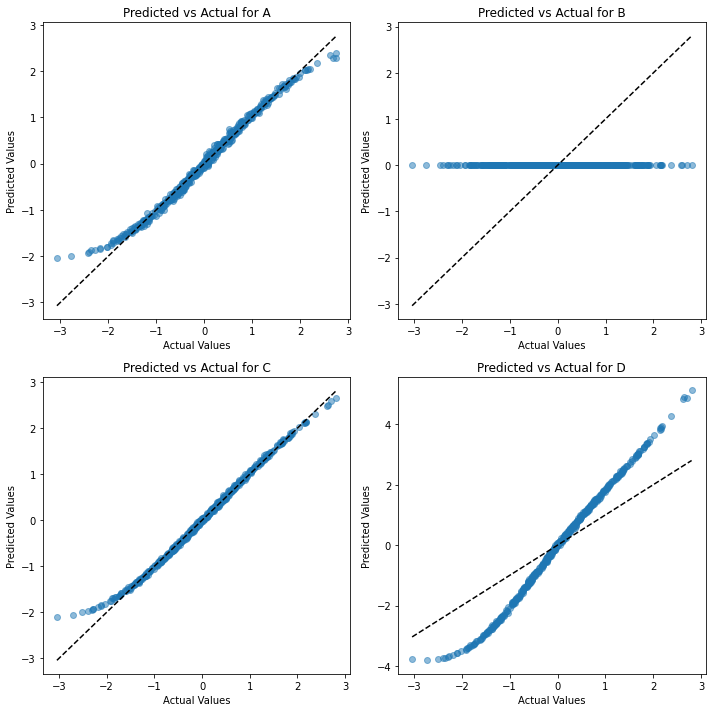

Epoch 3210, Loss: 0.25445532675595883


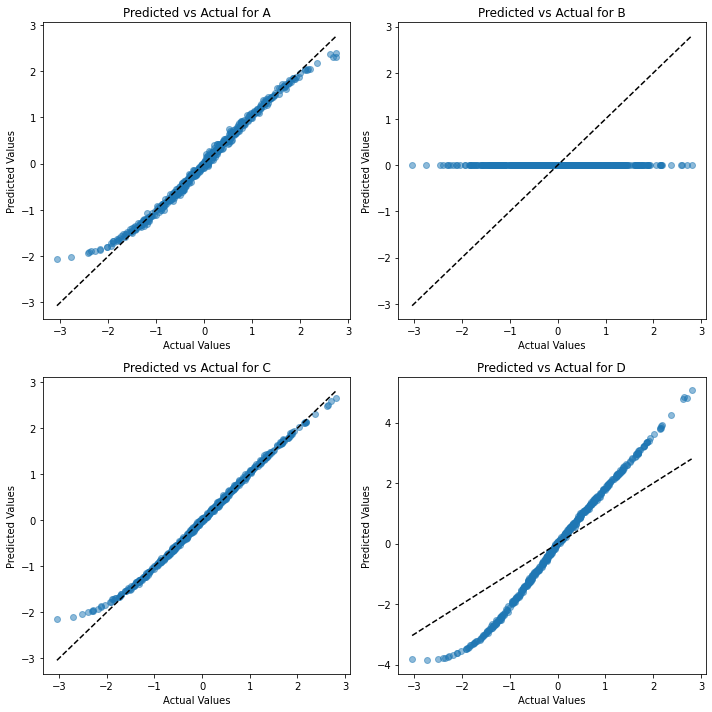

Epoch 3310, Loss: 0.25490964890327555


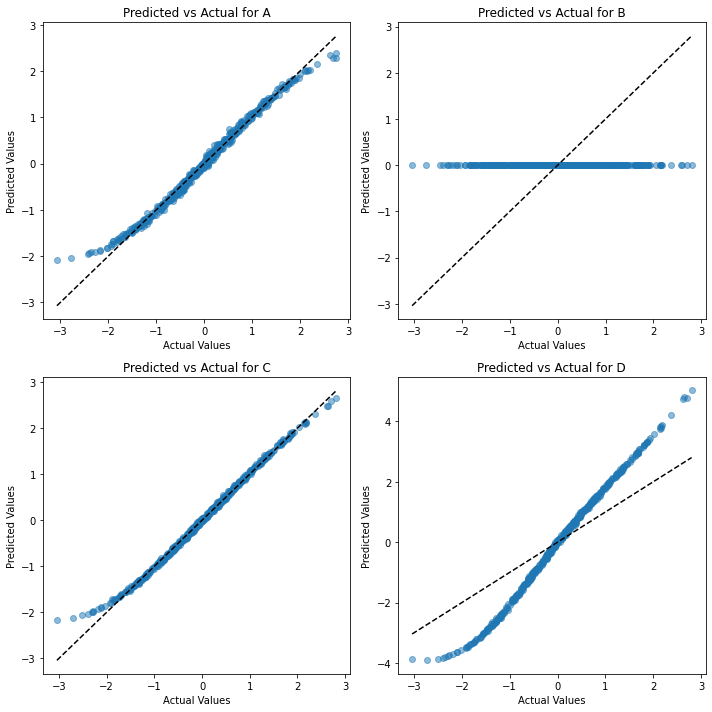

Epoch 3410, Loss: 0.2542338454685649


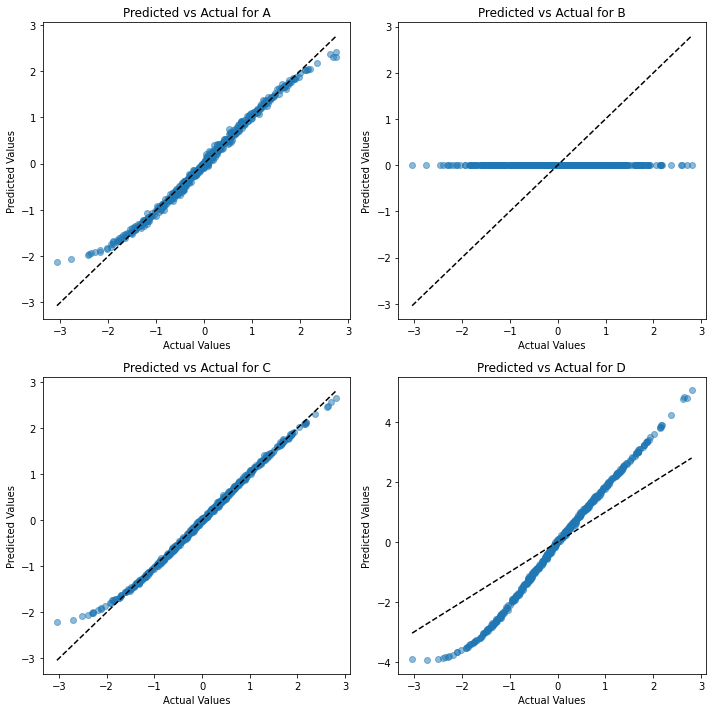

Epoch 3510, Loss: 0.2539200874804948


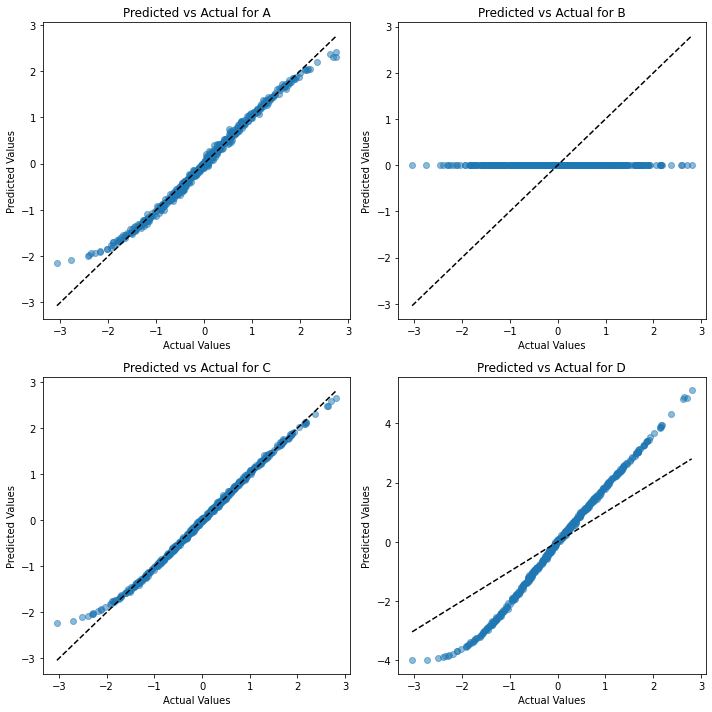

Epoch 3610, Loss: 0.2547470083615048


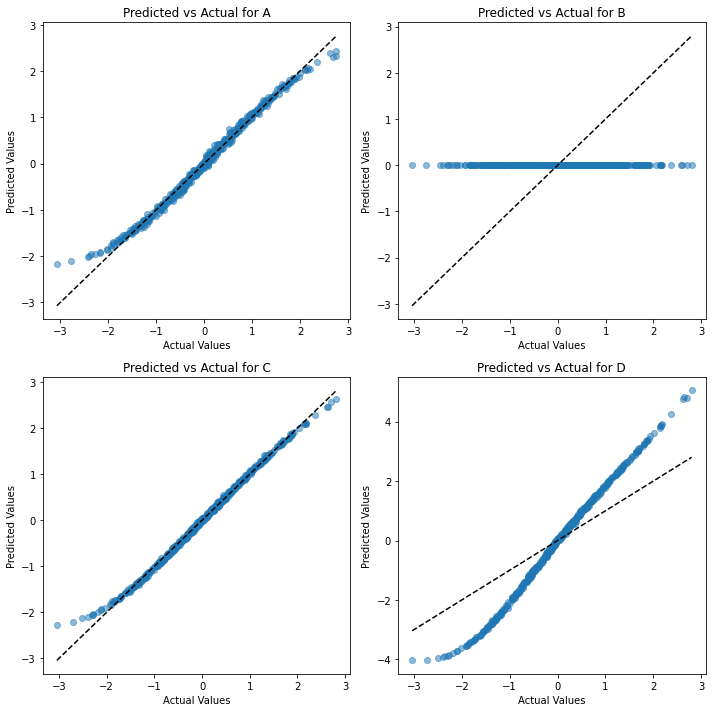

Epoch 3710, Loss: 0.25395247335105725


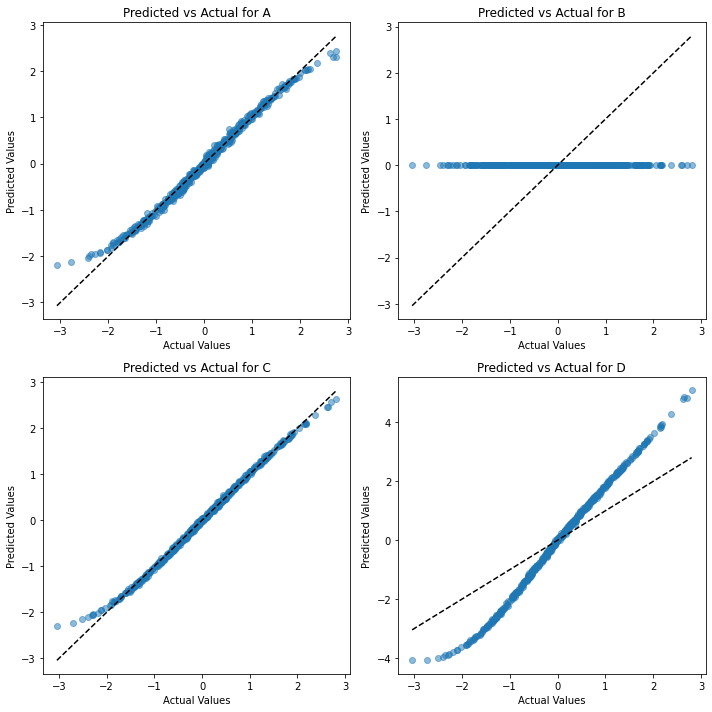

Epoch 3810, Loss: 0.25378345614013426


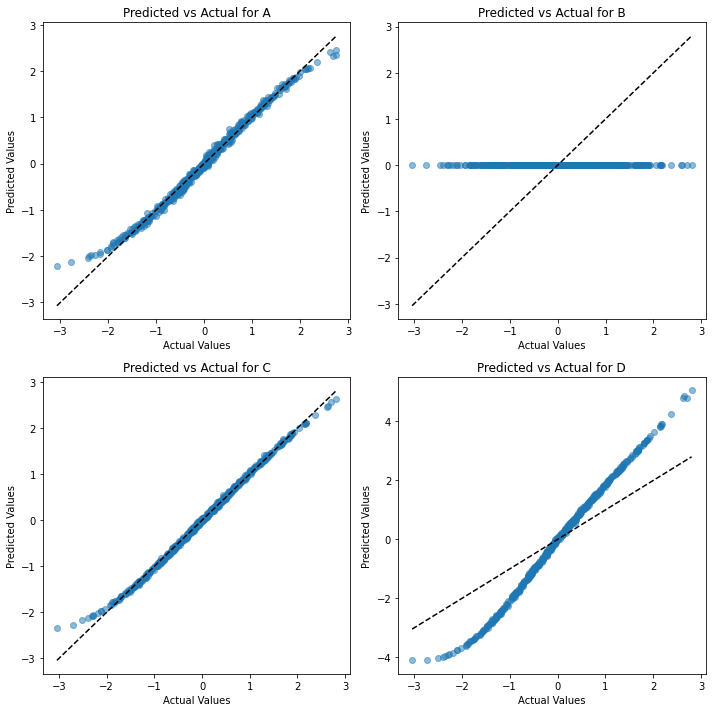

Epoch 3910, Loss: 0.2528471708870497


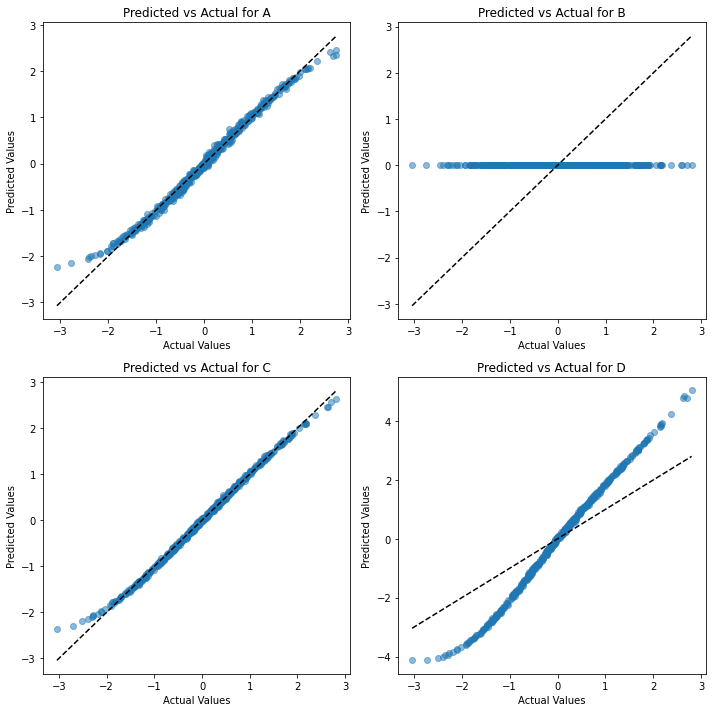

Epoch 4010, Loss: 0.25237419154418667


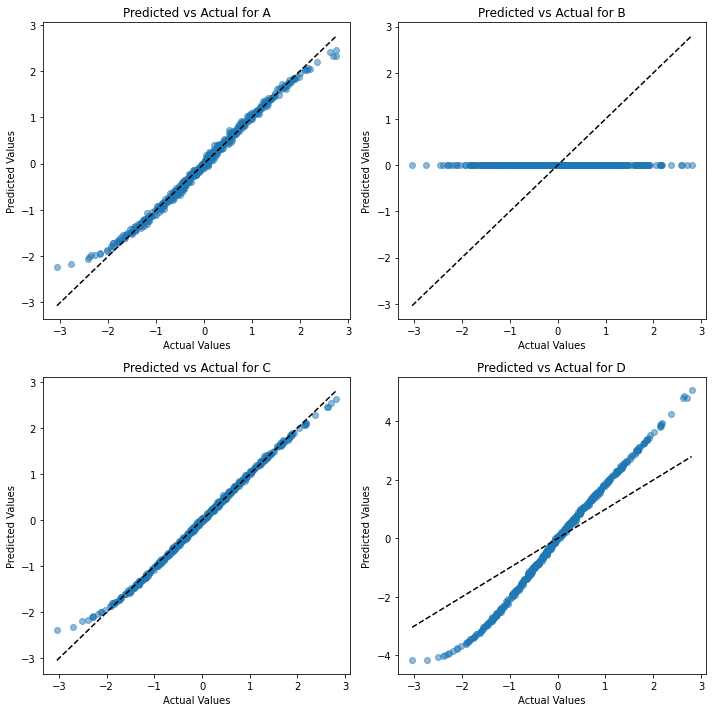

Epoch 4110, Loss: 0.2528089179078623


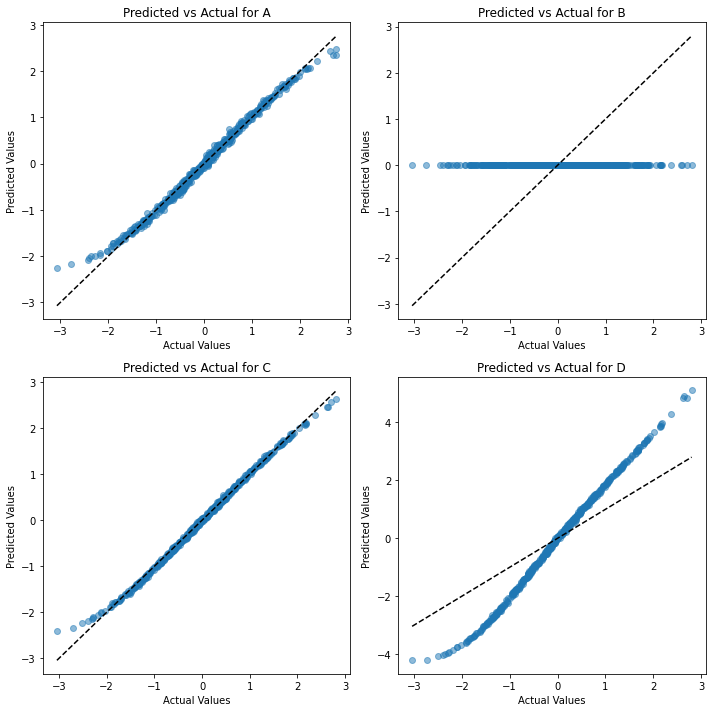

Epoch 4210, Loss: 0.25258755218799306


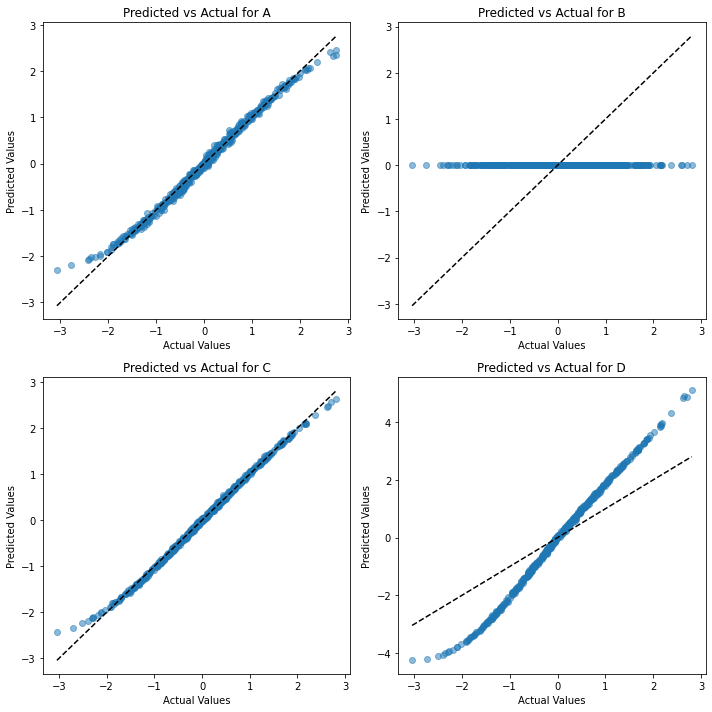

Epoch 4310, Loss: 0.2530391991169166


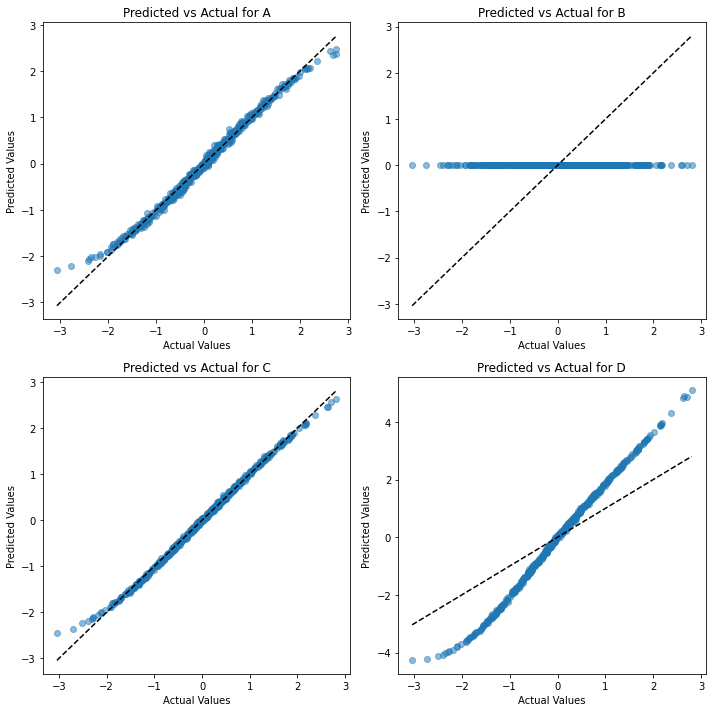

Epoch 4410, Loss: 0.2523710856707865


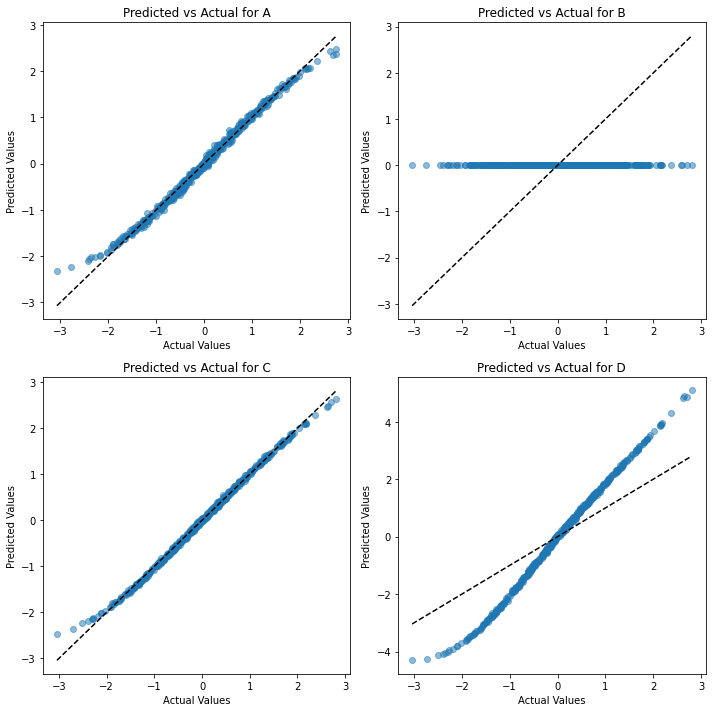

Epoch 4510, Loss: 0.25345344643581136


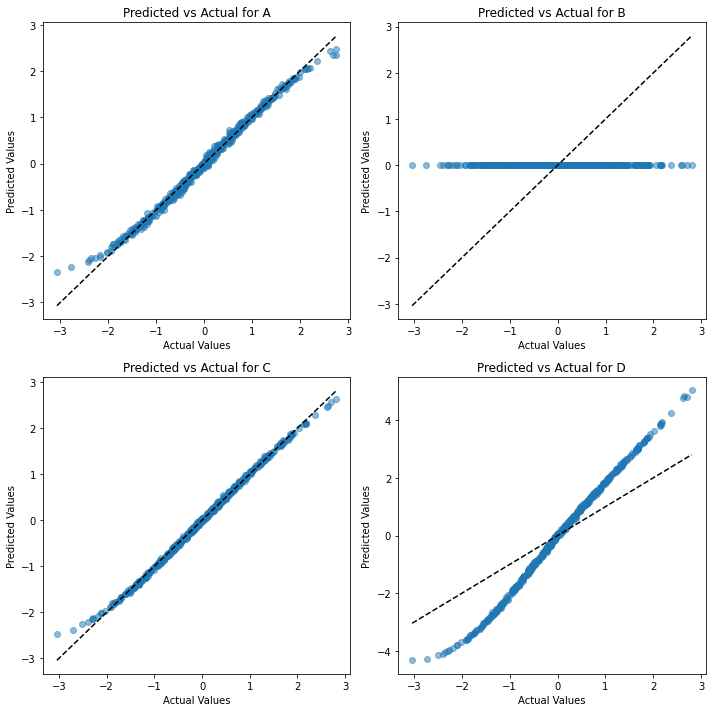

Epoch 4610, Loss: 0.25266047083080373


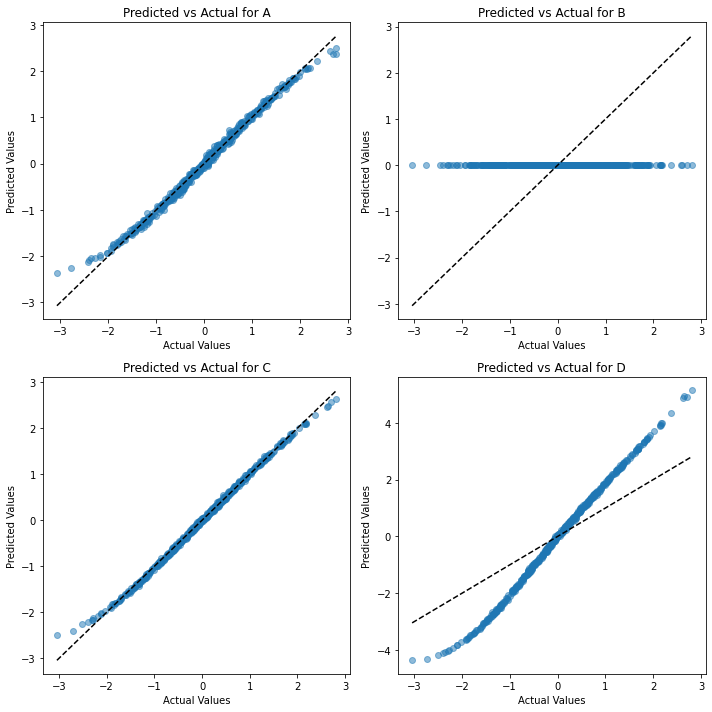

Epoch 4710, Loss: 0.2526109157877563


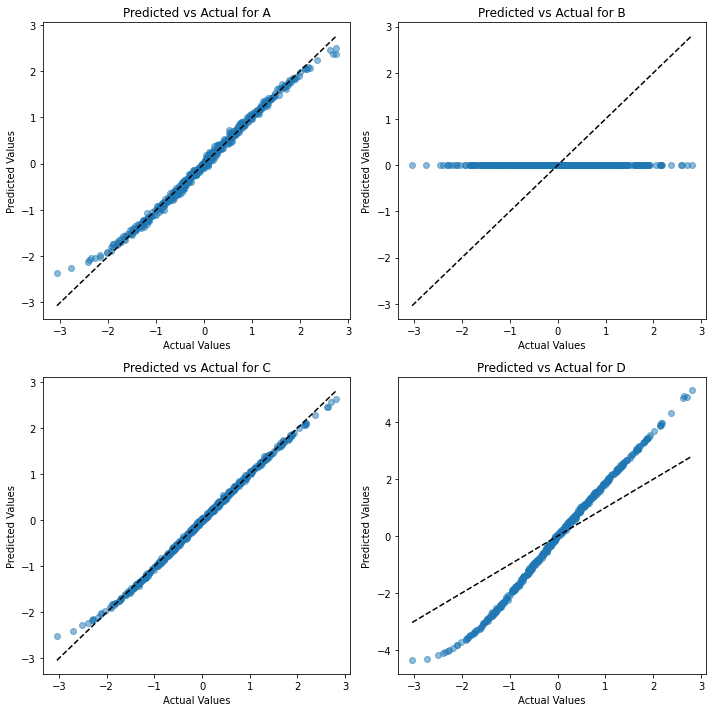

Epoch 4810, Loss: 0.25203983848453093


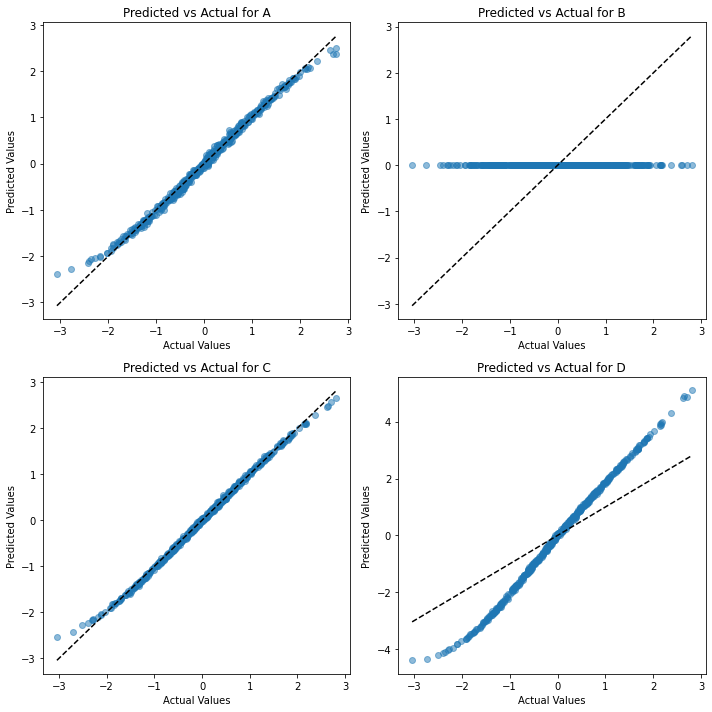

Epoch 4910, Loss: 0.25288397401736984
Finished Training


In [593]:
num_samples = 500  # Number of synthetic data samples
batch_size = 10  # Batch size for training
epochs = 5000  # Number of epochs for training

A = np.random.randn(num_samples)
B = 2 * A + 0.1 * np.random.randn(num_samples)
C = 2 * B + 0.1 * np.random.randn(num_samples)
D = 2 * A + 2 * C + 0.1 * np.random.randn(num_samples)
raw_data = np.column_stack((A, B, C, D))

# Standardize the data
mean = raw_data.mean(axis=0)
std = raw_data.std(axis=0)
data = (raw_data - mean) / std
data = torch.from_numpy(data).to(torch.float64)


input_size = data.shape[1]  
neurons_per_layer = [input_size,  8, 8, 8, 8, input_size]  

print('data shape:', data.shape)

dataset = TensorDataset(data, data)  # Using the same data as both input and target
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


  

class MaskedLinear(nn.Module):
    """A linear layer with an optional mask applied to its weights."""
    def __init__(self, in_features: int, out_features: int):
        """
        Initializes the MaskedLinear layer.
        
        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
        """
        super(MaskedLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.mask = None
        self.reset_parameters()
    
    def set_mask(self, mask: Union[np.ndarray, torch.Tensor]):
        """
        Sets the mask for the linear layer weights.

        Args:
            mask (Union[np.ndarray, torch.Tensor]): The mask to apply to the weights.
                Must be either a NumPy array or a PyTorch tensor.
        """
        if isinstance(mask, np.ndarray):
            # Convert from NumPy array to Tensor and set the correct dtype
            mask_tensor = torch.from_numpy(mask).to(torch.float64)
        elif isinstance(mask, torch.Tensor):
            # Ensure the tensor is the correct dtype
            mask_tensor = mask.to(torch.float64)
        else:
            raise TypeError("Mask must be a NumPy array or a PyTorch tensor.")

        self.mask = nn.Parameter(mask_tensor, requires_grad=False)
    
    def reset_parameters(self):
        """Initializes or resets the weights and biases of the layer."""
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
#         self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.01)
    
    def forward(self, input):
        if self.mask is not None:
            # Check if mask is not None

            masked_weight = self.weight.transpose(0, 1) * self.mask
            # Perform matrix multiplication using torch.matmul()
            return torch.matmul(input, masked_weight)
        else:
            # Perform matrix multiplication using torch.matmul()
            return torch.matmul(input, self.weight.transpose(0, 1))

    
class DAGAutoencoder(nn.Module):
    """A directed acyclic graph (DAG) autoencoder with optional input shuffling."""
    def __init__(self, neurons_per_layer: List[int], initial_adj_matrix: np.ndarray):
        """
        Initializes the DAGAutoencoder with specified neuron layers and an initial adjacency matrix.
        
        Args:
            neurons_per_layer (List[int]): List containing the number of neurons in each layer.
            initial_adj_matrix (np.ndarray): Initial adjacency matrix to set relationships between neurons.
        """
        super(DAGAutoencoder, self).__init__()
        self.initial_adj_matrix = initial_adj_matrix
        self.neurons_per_layer = neurons_per_layer
        self.layers = nn.ModuleList() 
        self.activations = nn.ModuleList()  
        self.original_masks = []  # This will be set initially and not changed
        self.current_masks = []  # Masks currently being used by the layers
        self.original_adj_matrix = torch.tensor(initial_adj_matrix, dtype=torch.float64)  # Store the original adjacency matrix
        self.was_shuffled = False

        for i in range(len(self.neurons_per_layer) - 1):
            linear_layer = MaskedLinear(neurons_per_layer[i], self.neurons_per_layer[i+1])
            self.layers.append(linear_layer)
            if i < len(self.neurons_per_layer) - 2:  
                self.activations.append(Swish())
    
    def initialize_masks(self, masks: List[torch.Tensor]):
        """
        Initializes the original masks for the autoencoder. This is intended to be called only once.
        
        Args:
            masks (List[torch.Tensor]): List of tensors representing the masks for each layer.
        """
        # Initialize original masks, only called once
        self.original_masks = [mask.clone() for mask in masks]
        self.set_masks(masks)
        
    def set_masks(self, masks: List[torch.Tensor]):
        """
        Applies masks to each layer in the autoencoder.
        
        Args:
            masks (List[torch.Tensor]): Masks to apply to the linear layers.
        """
        # Apply masks only to linear layers
        assert len(masks) == len(self.layers), "The number of masks must match the number of linear layers."
        for layer, mask in zip(self.layers, masks):
            layer.set_mask(mask)
                
    def forward(self, x: torch.Tensor, shuffle: bool = False) -> torch.Tensor:
        """
        Processes the input through the autoencoder, optionally shuffling input connections.

        Args:
            x (torch.Tensor): The input tensor.
            shuffle (bool, optional): Whether to shuffle the input connections. Defaults to False.
        
        Returns:
            torch.Tensor: The output of the autoencoder.
        """
        
        if shuffle:
            indices = torch.randperm(x.size(1))
            x = x[:, indices]
            shuffled_matrix = self.original_adj_matrix[indices][:, indices].numpy() 
            shuffled_masks = [torch.from_numpy(mask).float().to(torch.float64) for mask in expand_adjacency_matrix(self.neurons_per_layer[1:], shuffled_matrix)]
            self.set_masks(shuffled_masks)
            self.was_shuffled = True
            
        elif shuffle==False and self.was_shuffled:
            self.set_masks(self.original_masks)
            self.was_shuffled = False
            
        for linear, activation in zip(self.layers, self.activations):
            x = linear(x)
            x = activation(x)
        x = self.layers[-1](x)  # Apply the last linear layer (without ReLU if it's the output layer)
        return x
    
    
    
model = DAGAutoencoder(neurons_per_layer, initial_adj_matrix)

initial_adj_matrix = np.array([
    [0., 0, 0, 1],
    [1, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
])


initial_masks = [torch.from_numpy(mask).float().to(torch.float64) for mask in expand_adjacency_matrix(neurons_per_layer[1:], initial_adj_matrix)]
model.initialize_masks(initial_masks)


# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(inputs, shuffle=True)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)  # Multiply by batch size

    # Print statistics
    epoch_loss = running_loss / num_samples
    if epoch % 100 == 9:
        check_preds(dataset)
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

print('Finished Training')

In [594]:
# Test the model with one example
test_input = torch.randn(1, input_size).to(torch.float64)
model.eval()  # Set model to evaluation mode
test_output = model(test_input)
print("Test input:", test_input)
print("Reconstructed output:", test_output)

Test input: tensor([[ 0.3132, -0.3367,  1.9156, -1.7777]], dtype=torch.float64)
Reconstructed output: tensor([[-0.3550,  0.0000, -0.3510,  2.2282]], dtype=torch.float64,
       grad_fn=<MmBackward0>)


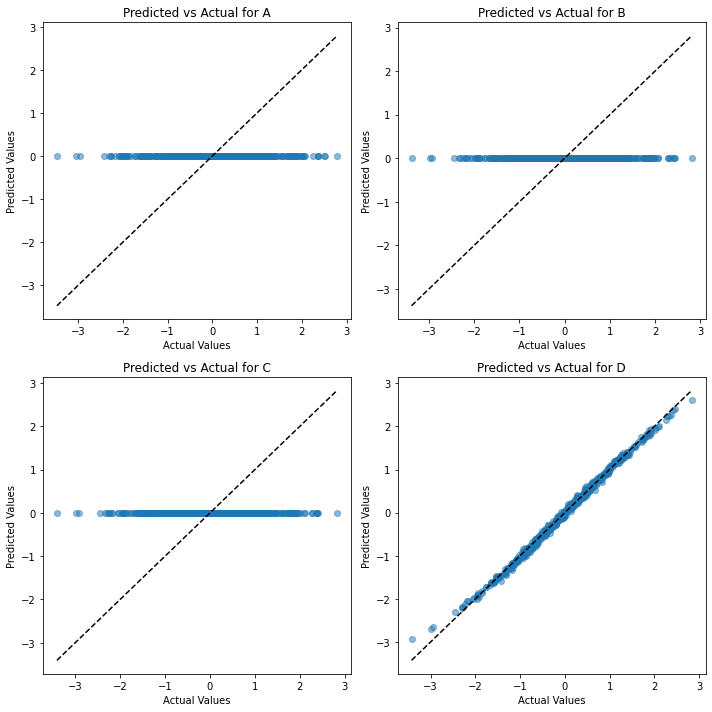

In [592]:
new_adj_matrix = np.array([
    [0., 0, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])
check_preds(dataset, new_adj_matrix=new_adj_matrix)

In [597]:
import networkx as nx
N= 1000
DAGnx = nx.DiGraph()

Ua = np.random.randn(N)
A = Ua
Ub = 0.1 * np.random.randn(N)
B = 2 * A + Ub
Uc = 0.1 * np.random.randn(N)
C = 2 * B + Uc
Uy = 0.1 * np.random.randn(N)
Y = 2 * A + 2 * C + Uy


B0 = Ub
B1 = 2 + Ub

C0 = 2*B0 + Uc
C1 = 2*B1 + Uc

Y0 = 2 * C0 + 0.1 * np.random.randn(N)
Y1 = 2 + 2 * C1 + 0.1 * np.random.randn(N)

all_data_dict = {'A': A, 'B': B, 'C': C, 'Y': Y}

# types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
var_types = {'A': 'cont', 'B': 'cont', 'C': 'cont', 'Y': 'cont'}

#         DAGnx.add_edges_from([('A', 'B'), ('B', 'C'), ('C', 'Y')])
DAGnx.add_edges_from([('A', 'B'), ('B', 'C'), ('C', 'Y'), ('A', 'Y')])


In [599]:

#input = Y0, Y1, preds0, preds1

# compute eATE

# compute ePEHE



1.9937549131346295

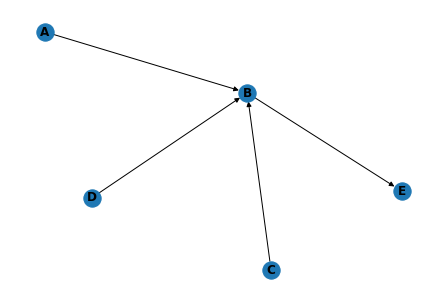

In [603]:
def remove_incoming_edges(graph, target_node):
    """
    Removes all incoming edges to a specified node in a directed graph.

    Args:
        graph (nx.DiGraph): A directed graph.
        target_node: The node for which all incoming edges should be removed.
    """
    # Check if the target node is in the graph
    if target_node not in graph:
        print(f"Node {target_node} not found in the graph.")
        return

    # List of all incoming edges to the target node
    incoming_edges = list(graph.in_edges(target_node))
    
    # Remove incoming edges
    graph.remove_edges_from(incoming_edges)

    print(f"All incoming edges to {target_node} have been removed.")

    
G = nx.DiGraph()

# Add some nodes and edges
G.add_edge('A', 'B')
G.add_edge('C', 'B')
G.add_edge('D', 'B')
G.add_edge('B', 'E')

# Node to remove all incoming edges from
target_node = 'B'

# Call the function
# remove_incoming_edges(G, target_node)

# Visualize the graph to confirm (optional, if you have matplotlib installed)
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()